## НАШ ПРОЕКТИК

# 1. Получение данных


In [1]:
import requests
import pandas as pd
from datetime import datetime

# Геокоординаты для нужных городов
city_coords = {
    'Moscow': (55.7558, 37.6176),
    'Saint_Petersburg': (59.9343, 30.3351),
    'Nizhny_Novgorod': (56.2965, 43.9361),
    'Kazan': (55.7963, 49.1088),
    'Ufa': (54.7388, 55.9721),
    'Novosibirsk': (55.0084, 82.9357),
    'Vladivostok': (43.1198, 131.8869)
}

# Функция получения данных из Open-Meteo
def get_weather_open_meteo(city: str, lat: float, lon: float,
                           start_date='2023-01-01', end_date='2023-12-31',
                           hourly=True) -> pd.DataFrame:
    base_url = 'https://archive-api.open-meteo.com/v1/archive'
    params = {
        'latitude': lat,
        'longitude': lon,
        'start_date': start_date,
        'end_date': end_date,
        'timezone': 'auto'
    }

    if hourly:
        params['hourly'] = 'temperature_2m'
    else:
        params['daily'] = 'temperature_2m_mean'

    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        raise Exception(f'Ошибка {response.status_code}: {response.text}')
    
    data = response.json()
    
    if hourly:
        time_list = data['hourly']['time']
        temp_list = data['hourly']['temperature_2m']
    else:
        time_list = data['daily']['time']
        temp_list = data['daily']['temperature_2m_mean']
    
    df = pd.DataFrame({
        'datetime': pd.to_datetime(time_list),
        'temperature': temp_list
    })
    df['city'] = city
    return df

# Сбор всех данных
hourly_data = []
daily_data = []

for city, (lat, lon) in city_coords.items():
    print(f"[⏱] Загружаем почасовые данные для: {city}")
    df_hourly = get_weather_open_meteo(city, lat, lon, hourly=True)
    hourly_data.append(df_hourly)
    
    print(f"[📆] Загружаем ежедневные данные для: {city}")
    df_daily = get_weather_open_meteo(city, lat, lon, hourly=False)
    daily_data.append(df_daily)

# Объединяем все города
df_hourly_all = pd.concat(hourly_data).reset_index(drop=True)
df_daily_all = pd.concat(daily_data).reset_index(drop=True)

# Агрегация по месяцам
df_monthly_all = (
    df_daily_all.copy()
    .assign(month=lambda df: df['datetime'].dt.to_period('M'))
    .groupby(['city', 'month'])
    .agg(temperature=('temperature', 'mean'))
    .reset_index()
)
df_monthly_all['month'] = df_monthly_all['month'].astype(str)

# Сохраняем все 3 таблицы
df_hourly_all.to_csv("weather_2023_hourly.csv", index=False)
df_daily_all.to_csv("weather_2023_daily.csv", index=False)
df_monthly_all.to_csv("weather_2023_monthly.csv", index=False)

# Функция для присвоения сезона по месяцу
def get_season(month: int) -> str:
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

# Почасовые данные
df_hourly_all['month'] = df_hourly_all['datetime'].dt.month
df_hourly_all['season'] = df_hourly_all['month'].apply(get_season)

# Ежедневные данные
df_daily_all['month'] = df_daily_all['datetime'].dt.month
df_daily_all['season'] = df_daily_all['month'].apply(get_season)

# Ежемесячные данные
df_monthly_all['month_num'] = pd.to_datetime(df_monthly_all['month']).dt.month
df_monthly_all['season'] = df_monthly_all['month_num'].apply(get_season)

# # Проверка
# print("\n📌 Почасовые данные с сезонами:")
# print(df_hourly_all[['datetime', 'temperature', 'city', 'season']].head())

# print("\n📌 Ежедневные данные с сезонами:")
# print(df_daily_all[['datetime', 'temperature', 'city', 'season']].head())

# print("\n📌 Ежемесячные данные с сезонами:")
# print(df_monthly_all[['month', 'temperature', 'city', 'season']].head())

[⏱] Загружаем почасовые данные для: Moscow
[📆] Загружаем ежедневные данные для: Moscow
[⏱] Загружаем почасовые данные для: Saint_Petersburg
[📆] Загружаем ежедневные данные для: Saint_Petersburg
[⏱] Загружаем почасовые данные для: Nizhny_Novgorod
[📆] Загружаем ежедневные данные для: Nizhny_Novgorod
[⏱] Загружаем почасовые данные для: Kazan
[📆] Загружаем ежедневные данные для: Kazan
[⏱] Загружаем почасовые данные для: Ufa
[📆] Загружаем ежедневные данные для: Ufa
[⏱] Загружаем почасовые данные для: Novosibirsk
[📆] Загружаем ежедневные данные для: Novosibirsk
[⏱] Загружаем почасовые данные для: Vladivostok
[📆] Загружаем ежедневные данные для: Vladivostok


# 2. Построение сетей случайных величин 

In [2]:
import networkx as nx

def build_correlation_graphs(df: pd.DataFrame, time_col: str, value_col: str = 'temperature') -> dict:
    results = {}
    for season in ['winter', 'spring', 'summer', 'autumn']:
        df_season = df[df['season'] == season]

        # pivot: time x city
        pivot_df = df_season.pivot(index=time_col, columns='city', values=value_col)

        # drop rows with missing values
        pivot_df = pivot_df.dropna()

        for method in ['pearson', 'kendall']:
            corr_matrix = pivot_df.corr(method=method)

            # Построим граф
            G = nx.Graph()
            for city in corr_matrix.columns:
                G.add_node(city)

            for i in corr_matrix.columns:
                for j in corr_matrix.columns:
                    if i != j:
                        weight = corr_matrix.loc[i, j]
                        G.add_edge(i, j, weight=weight)

            results[(season, method)] = G

    return results

In [3]:
# Пример: построить графы для почасовых данных
hourly_graphs = build_correlation_graphs(
    df=df_hourly_all,
    time_col='datetime'
)

# То же для дневных и месячных
daily_graphs = build_correlation_graphs(df_daily_all, time_col='datetime')
monthly_graphs = build_correlation_graphs(df_monthly_all.rename(columns={'month': 'datetime'}), time_col='datetime')

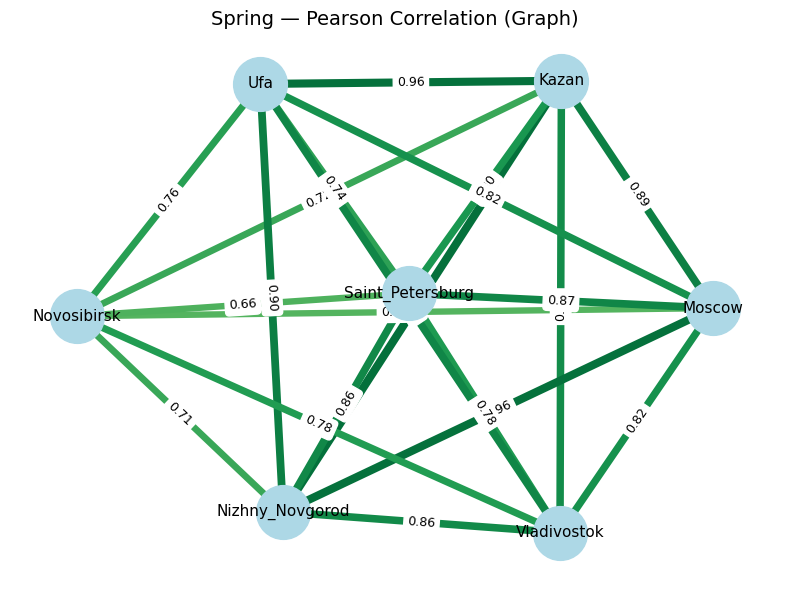

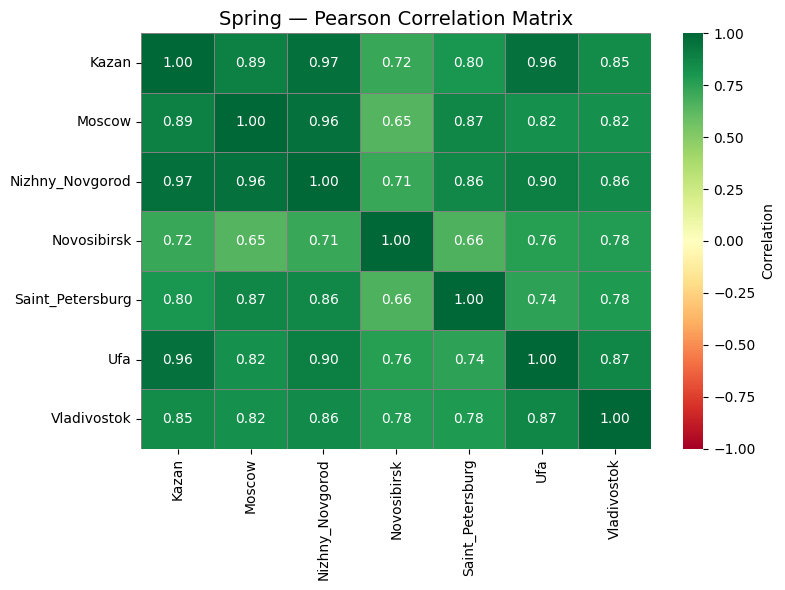

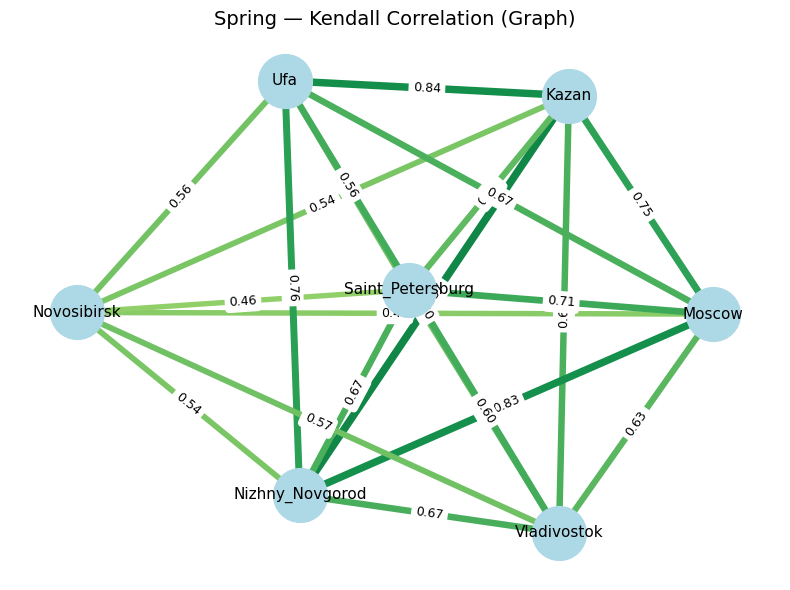

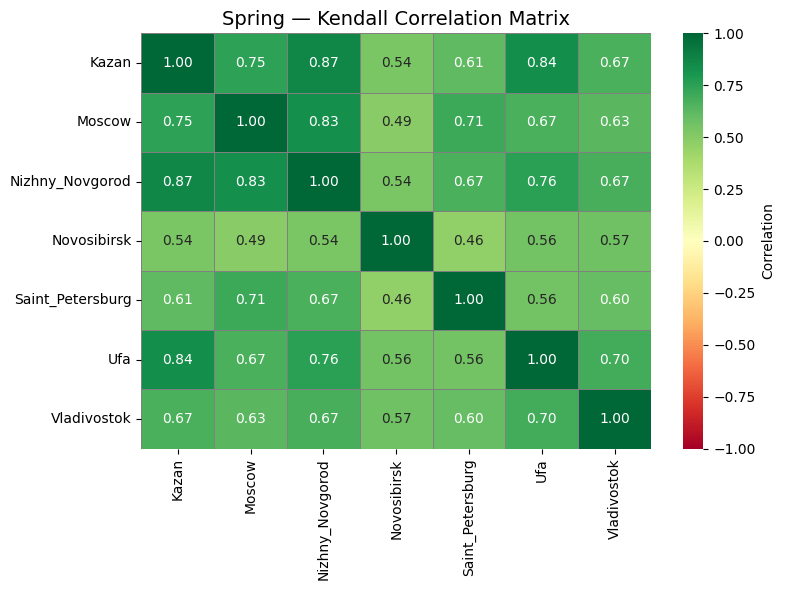

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

def draw_graph_for_season(graphs_dict, season='spring', method='pearson', threshold=None):
    G = graphs_dict.get((season, method))
    if not G or len(G.nodes) == 0:
        print(f"⚠️ Нет данных для {season.title()} ({method})")
        return

    pos = nx.spring_layout(G, seed=42)

    # Применим фильтр по порогу корреляции
    edges = [(u, v) for u, v, d in G.edges(data=True)
             if threshold is None or abs(d['weight']) >= threshold]
    if not edges:
        print(f"⚠️ Нет рёбер выше порога {threshold} для {season.title()}")
        return

    weights = [G[u][v]['weight'] for u, v in edges]
    abs_weights = [abs(w) for w in weights]

    # Цвета рёбер: от красного (-1) до зелёного (+1)
    edge_colors = [plt.cm.RdYlGn((w + 1) / 2) for w in weights]
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in edges}

    # Визуализация графа
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500)
    nx.draw_networkx_labels(G, pos, font_size=11)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors,
                           width=[2 + 4 * w for w in abs_weights])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title(f"{season.title()} — {method.title()} Correlation (Graph)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Построение корреляционной матрицы
    nodes = list(G.nodes)
    corr_matrix = pd.DataFrame(index=nodes, columns=nodes, dtype=float)

    for u in nodes:
        for v in nodes:
            if u == v:
                corr_matrix.loc[u, v] = 1.0
            elif G.has_edge(u, v):
                corr_matrix.loc[u, v] = G[u][v]['weight']
            elif G.has_edge(v, u):
                corr_matrix.loc[u, v] = G[v][u]['weight']
            else:
                corr_matrix.loc[u, v] = None

    # Визуализация тепловой карты
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap='RdYlGn', vmin=-1, vmax=1,
                linewidths=0.5, linecolor='gray', cbar_kws={"label": "Correlation"})
    plt.title(f"{season.title()} — {method.title()} Correlation Matrix", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Пример: сравнение по сезонам для дневных наблюдений
draw_graph_for_season(daily_graphs, method='pearson')
draw_graph_for_season(daily_graphs, method='kendall')

# 3. Построение графов с порогом корреляции + клики и независимые множества

In [5]:
#функция отсечения графа 

from networkx.algorithms.clique import find_cliques
from networkx.algorithms.approximation import maximum_independent_set

def threshold_graph(G: nx.Graph, threshold: float) -> nx.Graph:
    H = nx.Graph()
    H.add_nodes_from(G.nodes)
    for u, v, data in G.edges(data=True):
        if abs(data['weight']) >= threshold:
            H.add_edge(u, v, weight=data['weight'])
    return H

# функция которая находит клики + независимые множества
def analyze_graph(G: nx.Graph, threshold: float):
    G_thresh = threshold_graph(G, threshold)

    cliques = list(find_cliques(G_thresh))  # Все клики (не обязательно максимальные)
    max_clique_size = max(len(c) for c in cliques) if cliques else 0
    largest_cliques = [c for c in cliques if len(c) == max_clique_size]

    independent_set = maximum_independent_set(G_thresh)

    return {
        'thresholded_graph': G_thresh,
        'cliques': cliques,
        'largest_cliques': largest_cliques,
        'independent_set': independent_set
    }

In [6]:
# это пример использования функции выделения клик + независимых множеств

thresholds = [0.2, 0.4, 0.7]

for season in ['winter', 'spring', 'summer', 'autumn']:
    for method in ['pearson', 'kendall']:
        G = hourly_graphs.get((season, method))
        if G is None:
            continue
        print(f"\n--- {season.title()} | {method.title()} ---")
        for t in thresholds:
            result = analyze_graph(G, t)
            print(f"\nПорог: {t}")
            print(f"🔹 Кол-во вершин в кликах: {len(result['cliques'])}")
            print(f"🔹 Наибольшие клики: {result['largest_cliques']}")
            print(f"🔹 Независимое множество: {result['independent_set']}")


--- Winter | Pearson ---

Порог: 0.2
🔹 Кол-во вершин в кликах: 3
🔹 Наибольшие клики: [['Kazan', 'Ufa', 'Nizhny_Novgorod', 'Moscow', 'Saint_Petersburg']]
🔹 Независимое множество: {'Moscow', 'Novosibirsk'}

Порог: 0.4
🔹 Кол-во вершин в кликах: 4
🔹 Наибольшие клики: [['Kazan', 'Moscow', 'Nizhny_Novgorod', 'Saint_Petersburg'], ['Kazan', 'Moscow', 'Nizhny_Novgorod', 'Ufa']]
🔹 Независимое множество: {'Saint_Petersburg', 'Ufa'}

Порог: 0.7
🔹 Кол-во вершин в кликах: 5
🔹 Наибольшие клики: [['Kazan', 'Nizhny_Novgorod', 'Moscow'], ['Kazan', 'Nizhny_Novgorod', 'Ufa']]
🔹 Независимое множество: {'Kazan', 'Saint_Petersburg', 'Novosibirsk', 'Vladivostok'}

--- Winter | Kendall ---

Порог: 0.2
🔹 Кол-во вершин в кликах: 4
🔹 Наибольшие клики: [['Kazan', 'Moscow', 'Nizhny_Novgorod', 'Saint_Petersburg'], ['Kazan', 'Moscow', 'Nizhny_Novgorod', 'Ufa']]
🔹 Независимое множество: {'Saint_Petersburg', 'Ufa'}

Порог: 0.4
🔹 Кол-во вершин в кликах: 5
🔹 Наибольшие клики: [['Kazan', 'Nizhny_Novgorod', 'Moscow'], ['K

In [7]:
#функция визуализации отсеченного графа
def draw_thresholded_graph(G: nx.Graph, threshold=0.7, title=''):
    G_thresh = threshold_graph(G, threshold)
    
    if G_thresh.number_of_edges() == 0:
        print(f"⚠️ Нет рёбер выше порога {threshold}")
        return

    pos = nx.spring_layout(G_thresh, seed=42)

    edges = list(G_thresh.edges(data=True))
    weights = [d['weight'] for _, _, d in edges]
    abs_weights = [abs(w) for w in weights]
    edge_colors = [plt.cm.RdYlGn((w + 1) / 2) for w in weights]
    edge_labels = {(u, v): f"{w:.2f}" for u, v, d in edges if (w := d['weight'])}

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G_thresh, pos, node_color='lightblue', node_size=1500)
    nx.draw_networkx_labels(G_thresh, pos, font_size=11)
    nx.draw_networkx_edges(G_thresh, pos, edgelist=[(u, v) for u, v, _ in edges],
                           edge_color=edge_colors,
                           width=[2 + 4 * w for w in abs_weights])
    nx.draw_networkx_edge_labels(G_thresh, pos, edge_labels=edge_labels, font_size=9)
    
    plt.title(title or f"Thresholded Graph (≥ {threshold})", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

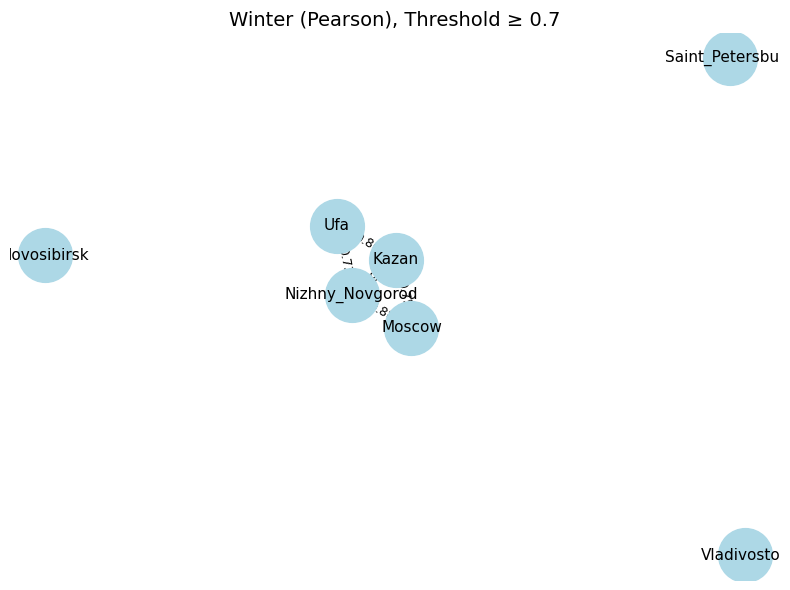

In [8]:
#визуализация зимнего графа пирсона из почасовых данных при пороге 0.7:
G = hourly_graphs[('winter', 'pearson')]
draw_thresholded_graph(G, threshold=0.7, title='Winter (Pearson), Threshold ≥ 0.7')

# 4. Анализ гипотезы

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, kendalltau, ttest_ind
import networkx as nx
from networkx.algorithms.clique import find_cliques
from networkx.algorithms.approximation import maximum_independent_set

# Функция отсечения графа по порогу корреляции
def threshold_graph(G: nx.Graph, threshold: float) -> nx.Graph:
    H = nx.Graph()
    H.add_nodes_from(G.nodes)
    for u, v, data in G.edges(data=True):
        if abs(data['weight']) >= threshold:
            H.add_edge(u, v, weight=data['weight'])
    return H

# Функция для анализа графа: клики, независимые множества
def analyze_graph(G: nx.Graph, threshold: float):
    G_thresh = threshold_graph(G, threshold)

    cliques = list(find_cliques(G_thresh))  # Все клики (не обязательно максимальные)
    max_clique_size = max(len(c) for c in cliques) if cliques else 0
    largest_cliques = [c for c in cliques if len(c) == max_clique_size]

    independent_set = maximum_independent_set(G_thresh)

    return {
        'thresholded_graph': G_thresh,
        'cliques': cliques,
        'largest_cliques': largest_cliques,
        'independent_set': independent_set
    }

def compare_graphs_extended(data, methods=['pearson', 'kendall'], threshold=0.5, verbose=True):
    results = []

    seasons = ['winter', 'spring', 'summer', 'autumn']
    freqs = ['hourly', 'daily', 'monthly']
    freq_labels = {
        'hourly': 'Почасовые',
        'daily': 'Дневные',
        'monthly': 'Месячные'
    }

    hypothesis_rejected_stat = False  # Флаг для отслеживания отклонения гипотезы по статистике
    hypothesis_rejected_struct = False  # Флаг для отслеживания отклонения гипотезы по структуре графов

    for freq1 in freqs:
        for freq2 in freqs:
            for season1 in seasons:
                for season2 in seasons:
                    for method1 in methods:
                        for method2 in methods:
                            
                            # Генерация графов
                            df1 = data[season1][freq1]  # Температуры для первого графа
                            df2 = data[season2][freq2]  # Температуры для второго графа

                            # Строим графы с корреляциями
                            G1 = build_graph(df1, method=method1, threshold=threshold)
                            G2 = build_graph(df2, method=method2, threshold=threshold)

                            # Применяем порог корреляции для отсечения рёбер графов
                            analysis1 = analyze_graph(G1, threshold)
                            analysis2 = analyze_graph(G2, threshold)

                            G1_thresh = analysis1['thresholded_graph']
                            G2_thresh = analysis2['thresholded_graph']

                            # Проверка статистической гипотезы (t-тест для независимых выборок)
                            mat1 = np.array([G1_thresh[u][v]['weight'] for u, v in G1_thresh.edges()])
                            mat2 = np.array([G2_thresh[u][v]['weight'] for u, v in G2_thresh.edges()])
                            t_stat, p_value = ttest_ind(mat1, mat2, equal_var=False)

                            # Проверка по структуре графов (сравнение кликов и независимых множеств)
                            cliques1 = analysis1['largest_cliques']
                            cliques2 = analysis2['largest_cliques']
                            independent_set1 = analysis1['independent_set']
                            independent_set2 = analysis2['independent_set']

                            # Сравнение структуры графов: если размеры максимальных кликов одинаковы и независимые множества схожи
                            clique_comparison = len(cliques1) == len(cliques2)
                            independent_set_comparison = len(independent_set1) == len(independent_set2)

                            # Записываем результаты
                            results.append({
                                'freq1': freq_labels[freq1],
                                'season1': season1,
                                'method1': method1,
                                'freq2': freq_labels[freq2],
                                'season2': season2,
                                'method2': method2,
                                'mse': round(mean_squared_error(mat1, mat2), 5),
                                'corr': round(pearsonr(mat1, mat2)[0], 5) if method1 == 'pearson' else round(kendalltau(mat1, mat2)[0], 5),
                                't_statistic': round(t_stat, 5),
                                'p_value': round(p_value, 5),
                                'clique_comparison': clique_comparison,
                                'independent_set_comparison': independent_set_comparison
                            })

                            # Проверка гипотезы для статистики
                            if p_value < 0.05:
                                hypothesis_rejected_stat = True

                            # Проверка гипотезы для структуры графов
                            if not clique_comparison or not independent_set_comparison:
                                hypothesis_rejected_struct = True

    df = pd.DataFrame(results)

    if verbose:
        print(df.head(10))  # Пример вывода
        print(f"\nВсего сравнений: {len(df)}")

    # Вывод результатов
    print("\nРезультаты анализа:")
    print("------------------------------------------------------")
    for idx, row in df.iterrows():
        print(f"Сезоны: {row['season1']} vs {row['season2']}, Частоты: {row['freq1']} vs {row['freq2']}")
        print(f"Метод 1: {row['method1']}, Метод 2: {row['method2']}")
        print(f"Корреляция: {row['corr']}, MSE: {row['mse']}")
        print(f"t-статистика: {row['t_statistic']}, p-value: {row['p_value']}")
        print(f"Сравнение кликов: {row['clique_comparison']}")
        print(f"Сравнение независимых множеств: {row['independent_set_comparison']}")
        print("------------------------------------------------------")

    # Визуализация
    plot_correlation_heatmap(df)
    plot_mse_heatmap(df)
    plot_method_comparison(df)

    # Вывод результата гипотезы
    if hypothesis_rejected_stat:
        print("\nСтатистическая гипотеза отклоняется: существуют статистически значимые различия между графами.")
    else:
        print("\nСтатистическая гипотеза принимается: нет статистически значимых различий между графами.")

    if hypothesis_rejected_struct:
        print("\nГипотеза на основе структуры графов отклоняется: графы имеют значительные различия в структуре.")
    else:
        print("\nГипотеза на основе структуры графов принимается: графы не имеют значительных различий.")

    return df

# Визуализация
def plot_correlation_heatmap(df):
    pivot_corr = df.pivot_table(index=['season1', 'season2'], columns=['freq1', 'freq2'], values='corr')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Корреляции между графами по сезонам и частотам", fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_mse_heatmap(df):
    pivot_mse = df.pivot_table(index=['season1', 'season2'], columns=['freq1', 'freq2'], values='mse')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_mse, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=0.5)
    plt.title("MSE (среднеквадратичные ошибки) между графами по сезонам и частотам", fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_method_comparison(df):
    # Сравнение корреляций Пирсона и Кендалла для одинаковых сезонов и частот
    comparison_df = df[df['method1'] == df['method2']]
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='season1', y='corr', hue='method1', data=comparison_df)
    plt.title("Сравнение корреляций Пирсона и Кендалла для одинаковых сезонов и частот")
    plt.tight_layout()
    plt.show()

In [17]:
def build_pruned_correlation_graphs(df: pd.DataFrame, time_col: str, threshold: float = 0.5, value_col: str = 'temperature') -> dict:
    """Построение графов корреляции с отсечением слабых связей"""
    results = {}
    for season in ['winter', 'spring', 'summer', 'autumn']:
        df_season = df[df['season'] == season]
        
        # pivot: time x city
        pivot_df = df_season.pivot(index=time_col, columns='city', values=value_col)
        pivot_df = pivot_df.dropna()

        for method in ['pearson', 'kendall']:
            corr_matrix = pivot_df.corr(method=method)

            # Построение графа с отсечением
            G = nx.Graph()
            for city in corr_matrix.columns:
                G.add_node(city)

            for i in corr_matrix.columns:
                for j in corr_matrix.columns:
                    if i != j and abs(corr_matrix.loc[i, j]) > threshold:
                        weight = corr_matrix.loc[i, j]
                        G.add_edge(i, j, weight=weight)

            results[(season, method, threshold)] = G

    return results

In [18]:
def analyze_graphs(graphs_dict: dict) -> pd.DataFrame:
    """Анализ характеристик графов"""
    analysis_results = []
    
    for key, G in graphs_dict.items():
        season, method, threshold = key
        
        # Основные характеристики графа
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_clustering = nx.average_clustering(G)
        
        # Центральность
        degree_centrality = nx.degree_centrality(G)
        avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
        
        analysis_results.append({
            'season': season,
            'method': method,
            'threshold': threshold,
            'num_nodes': num_nodes,
            'num_edges': num_edges,
            'density': density,
            'avg_clustering': avg_clustering,
            'avg_degree_centrality': avg_degree_centrality
        })
    
    return pd.DataFrame(analysis_results)

In [19]:
from scipy import stats

def test_hypotheses(analysis_df: pd.DataFrame) -> None:
    """Проверка статистических гипотез"""
    # Пример гипотезы: плотность графа зимой выше, чем летом (для pearson)
    winter_data = analysis_df[(analysis_df['season'] == 'winter') & (analysis_df['method'] == 'pearson')]['density']
    summer_data = analysis_df[(analysis_df['season'] == 'summer') & (analysis_df['method'] == 'pearson')]['density']
    
    # t-тест для сравнения средних
    t_stat, p_val = stats.ttest_ind(winter_data, summer_data)
    print(f"Сравнение плотности графов (зима vs лето): t={t_stat:.3f}, p={p_val:.3f}")
    
    if p_val < 0.05:
        print("Отвергаем нулевую гипотезу: плотность графов зимой и летом различается")
        if winter_data.mean() > summer_data.mean():
            print("Плотность графов зимой выше, чем летом")
        else:
            print("Плотность графов летом выше, чем зимой")
    else:
        print("Нет оснований отвергать нулевую гипотезу: плотность графов зимой и летом не различается")

Сравнение плотности графов (зима vs лето): t=0.822, p=0.457
Нет оснований отвергать нулевую гипотезу: плотность графов зимой и летом не различается


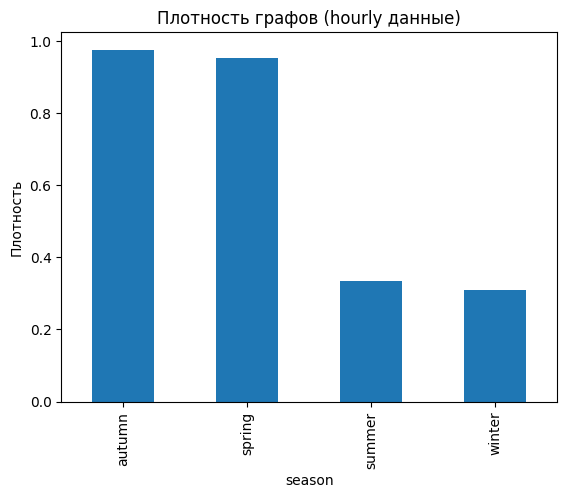

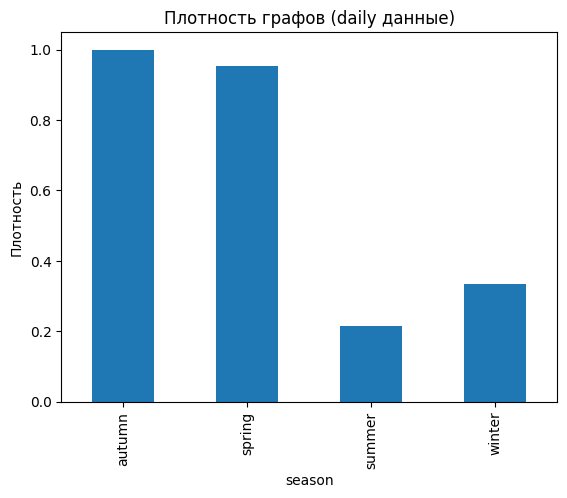

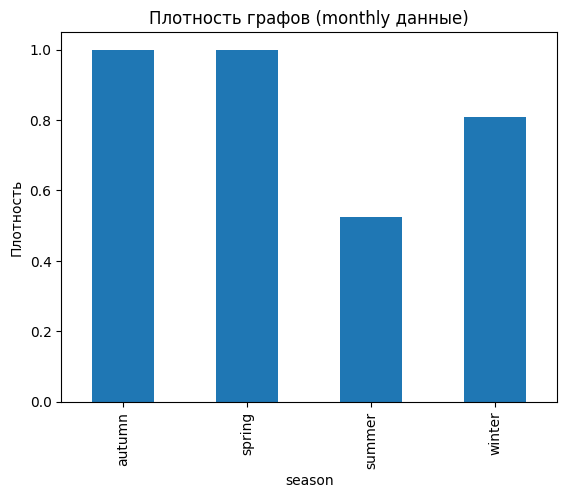

In [20]:
# Построение графов с отсечением
pruned_hourly_graphs = build_pruned_correlation_graphs(df_hourly_all, time_col='datetime', threshold=0.5)
pruned_daily_graphs = build_pruned_correlation_graphs(df_daily_all, time_col='datetime', threshold=0.5)
pruned_monthly_graphs = build_pruned_correlation_graphs(df_monthly_all.rename(columns={'month': 'datetime'}), time_col='datetime', threshold=0.5)

# Анализ графов
hourly_analysis = analyze_graphs(pruned_hourly_graphs)
daily_analysis = analyze_graphs(pruned_daily_graphs)
monthly_analysis = analyze_graphs(pruned_monthly_graphs)

# Объединение результатов
full_analysis = pd.concat([hourly_analysis, daily_analysis, monthly_analysis])
full_analysis['data_type'] = ['hourly']*len(hourly_analysis) + ['daily']*len(daily_analysis) + ['monthly']*len(monthly_analysis)

# Проверка гипотез
test_hypotheses(full_analysis)

# Визуализация результатов
import matplotlib.pyplot as plt

# Пример визуализации плотности графов по сезонам
for data_type in ['hourly', 'daily', 'monthly']:
    subset = full_analysis[full_analysis['data_type'] == data_type]
    subset.groupby('season')['density'].mean().plot(kind='bar', title=f'Плотность графов ({data_type} данные)')
    plt.ylabel('Плотность')
    plt.show()

In [21]:
from scipy.stats import kruskal

def test_correlation_stability(df, time_col, value_col='temperature'):
    results = []
    for season in ['winter', 'spring', 'summer', 'autumn']:
        df_season = df[df['season'] == season]
        pivot_df = df_season.pivot(index=time_col, columns='city', values=value_col).corr()
        correlations = pivot_df.values[np.triu_indices_from(pivot_df, k=1)]  # Убираем диагональ
        results.append(correlations)
    
    # Критерий Краскела-Уоллиса (непараметрический аналог ANOVA)
    stat, p_value = kruskal(*results)
    print(f"Сезонные различия (p-value): {p_value:.4f}")
    if p_value < 0.05:
        print("Отвергаем H₀: связи зависят от сезона.")
    else:
        print("Нет оснований отвергать H₀: связи постоянны.")

In [22]:
from scipy.stats import friedmanchisquare

# Сравниваем плотность графов для hourly/daily/monthly
friedman_result = friedmanchisquare(
    hourly_analysis['density'],
    daily_analysis['density'],
    monthly_analysis['density']
)
print(f"Различия по частоте данных (p-value): {friedman_result.pvalue:.4f}")

Различия по частоте данных (p-value): 0.0131


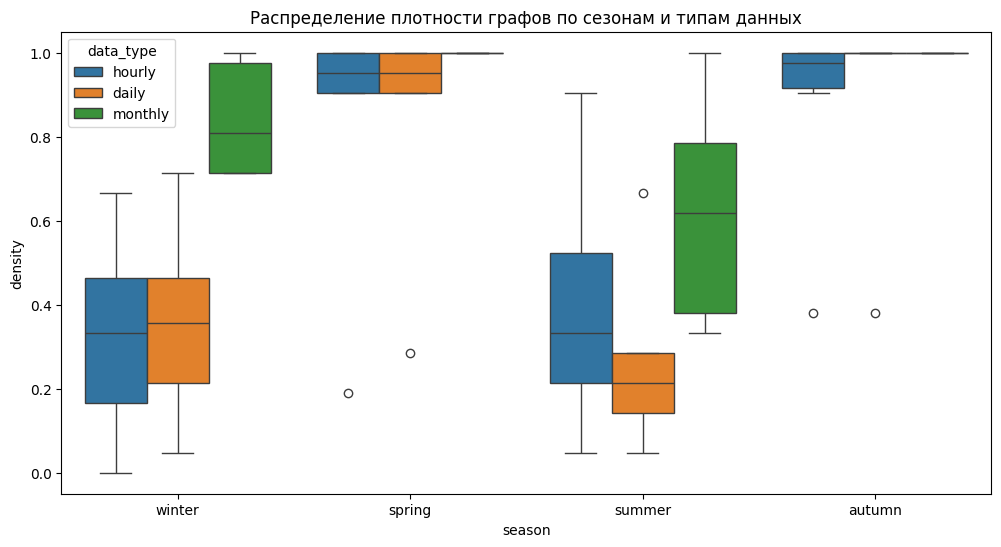


=== Анализ для порога 0.3 ===
Критерий Краскела-Уоллиса для сезонов (p-value): 0.0616
Критерий Фридмана для частоты данных (p-value): 0.1266
Сравнение зимы и лета (t-test, p-value): 1.0000
Принимаем H₀: связи ПОСТОЯННЫ

=== Анализ для порога 0.5 ===
Критерий Краскела-Уоллиса для сезонов (p-value): 0.0197
Критерий Фридмана для частоты данных (p-value): 0.0131
Сравнение зимы и лета (t-test, p-value): 0.4573
Отвергаем H₀: связи ЗАВИСЯТ от сезона или частоты данных

=== Анализ для порога 0.7 ===
Критерий Краскела-Уоллиса для сезонов (p-value): 0.0294
Критерий Фридмана для частоты данных (p-value): 0.0016
Сравнение зимы и лета (t-test, p-value): 0.5467
Отвергаем H₀: связи ЗАВИСЯТ от сезона или частоты данных


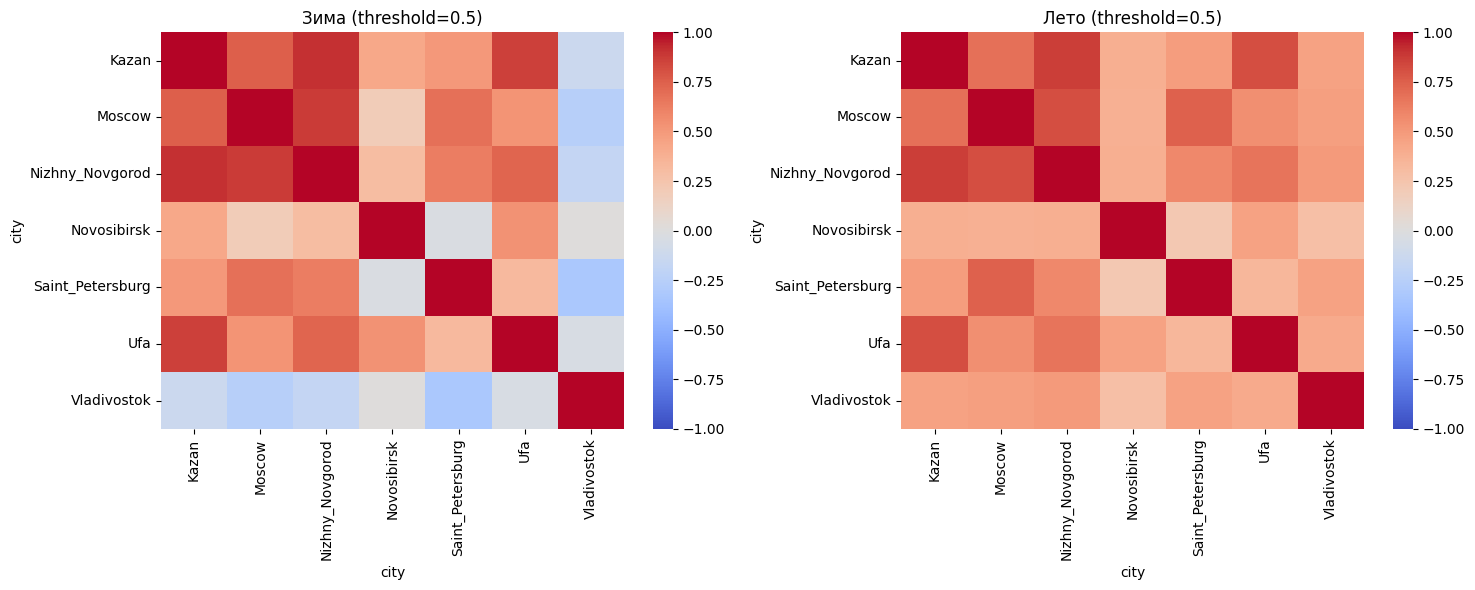

In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, friedmanchisquare, ttest_ind

# Загрузка данных (предполагаем, что данные уже подготовлены)
hourly_data = df_hourly_all
daily_data = df_daily_all
monthly_data = df_monthly_all

# Функция для построения отсеченных графов
def build_pruned_graphs(df, time_col, thresholds, value_col='temperature'):
    results = {}
    for season in ['winter', 'spring', 'summer', 'autumn']:
        df_season = df[df['season'] == season]
        pivot_df = df_season.pivot(index=time_col, columns='city', values=value_col).dropna()
        
        for method in ['pearson', 'kendall']:
            corr_matrix = pivot_df.corr(method=method)
            for threshold in thresholds:
                G = nx.Graph()
                for city in corr_matrix.columns:
                    G.add_node(city)
                
                for i in corr_matrix.columns:
                    for j in corr_matrix.columns:
                        if i != j and abs(corr_matrix.loc[i, j]) > threshold:
                            G.add_edge(i, j, weight=corr_matrix.loc[i, j])
                
                results[(season, method, threshold)] = {
                    'graph': G,
                    'corr_matrix': corr_matrix
                }
    return results

# Функция для анализа графов
def analyze_graphs(graphs_dict):
    analysis = []
    for key, data in graphs_dict.items():
        season, method, threshold = key
        G = data['graph']
        
        analysis.append({
            'season': season,
            'method': method,
            'threshold': threshold,
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'density': nx.density(G),
            'avg_clustering': nx.average_clustering(G),
            'avg_degree': sum(dict(G.degree()).values()) / len(G)
        })
    return pd.DataFrame(analysis)

# Задаем пороги корреляции вручную
thresholds = [0.3, 0.5, 0.7]  # Можно изменить значения

# Строим графы для всех типов данных
hourly_graphs = build_pruned_graphs(hourly_data, 'datetime', thresholds)
daily_graphs = build_pruned_graphs(daily_data, 'datetime', thresholds)
monthly_graphs = build_pruned_graphs(monthly_data, 'month', thresholds)

# Анализируем графы
hourly_analysis = analyze_graphs(hourly_graphs)
daily_analysis = analyze_graphs(daily_graphs)
monthly_analysis = analyze_graphs(monthly_graphs)

# Объединяем результаты
full_analysis = pd.concat([
    hourly_analysis.assign(data_type='hourly'),
    daily_analysis.assign(data_type='daily'),
    monthly_analysis.assign(data_type='monthly')
])

# Визуализация распределения плотности графов
plt.figure(figsize=(12, 6))
sns.boxplot(data=full_analysis, x='season', y='density', hue='data_type')
plt.title('Распределение плотности графов по сезонам и типам данных')
plt.show()

# Статистическая проверка гипотезы
def test_hypothesis(analysis_df, threshold):
    print(f"\n=== Анализ для порога {threshold} ===")
    
    # Проверка влияния сезона
    seasonal_groups = [group['density'].values for name, group in analysis_df[
        (analysis_df['threshold'] == threshold) & 
        (analysis_df['method'] == 'pearson')
    ].groupby('season')]
    
    _, p_season = kruskal(*seasonal_groups)
    print(f"Критерий Краскела-Уоллиса для сезонов (p-value): {p_season:.4f}")
    
    # Проверка влияния частоты данных
    freq_groups = [group['density'].values for name, group in analysis_df[
        (analysis_df['threshold'] == threshold)
    ].groupby('data_type')]
    
    _, p_freq = friedmanchisquare(*freq_groups)
    print(f"Критерий Фридмана для частоты данных (p-value): {p_freq:.4f}")
    
    # Дополнительно: сравнение зимы и лета
    winter = analysis_df[
        (analysis_df['season'] == 'winter') & 
        (analysis_df['threshold'] == threshold) &
        (analysis_df['method'] == 'pearson')
    ]['density']
    
    summer = analysis_df[
        (analysis_df['season'] == 'summer') & 
        (analysis_df['threshold'] == threshold) &
        (analysis_df['method'] == 'pearson')
    ]['density']
    
    _, p_winter_summer = ttest_ind(winter, summer)
    print(f"Сравнение зимы и лета (t-test, p-value): {p_winter_summer:.4f}")
    
    # Вывод по гипотезе
    if p_season < 0.05 or p_freq < 0.05:
        print("Отвергаем H₀: связи ЗАВИСЯТ от сезона или частоты данных")
    else:
        print("Принимаем H₀: связи ПОСТОЯННЫ")

# Проводим анализ для каждого порога
for thresh in thresholds:
    test_hypothesis(full_analysis, thresh)

# Визуализация корреляционных матриц для примера (зима/лето, threshold=0.5)
def plot_corr_matrices(graphs_dict, threshold):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Зима
    winter_corr = graphs_dict[('winter', 'pearson', threshold)]['corr_matrix']
    sns.heatmap(winter_corr, ax=axes[0], cmap='coolwarm', vmin=-1, vmax=1)
    axes[0].set_title(f'Зима (threshold={threshold})')
    
    # Лето
    summer_corr = graphs_dict[('summer', 'pearson', threshold)]['corr_matrix']
    sns.heatmap(summer_corr, ax=axes[1], cmap='coolwarm', vmin=-1, vmax=1)
    axes[1].set_title(f'Лето (threshold={threshold})')
    
    plt.tight_layout()
    plt.show()

plot_corr_matrices(hourly_graphs, 0.5)

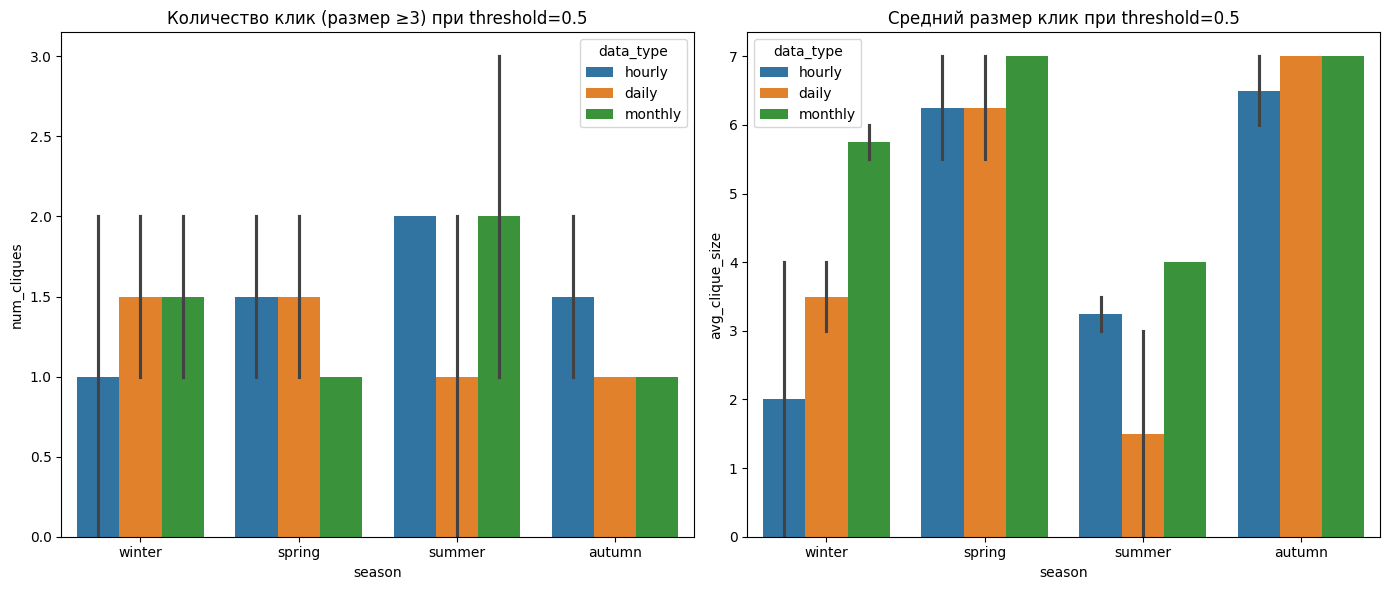


=== Устойчивые клики (hourly, pearson, threshold=0.5) ===
Нет клик, общих для всех сезонов

=== Устойчивые клики (daily, pearson, threshold=0.5) ===
Нет клик, общих для всех сезонов

=== Устойчивые клики (monthly, pearson, threshold=0.5) ===
Нет клик, общих для всех сезонов


In [27]:
def analyze_and_compare_cliques(graphs_dict, min_clique_size=3):
    """
    Анализирует и сравнивает кликовую структуру графов
    
    Параметры:
    ----------
    graphs_dict : dict
        Словарь с графами (результат функции build_pruned_graphs)
    min_clique_size : int
        Минимальный размер клики для анализа (по умолчанию 3)
    
    Возвращает:
    -----------
    pd.DataFrame
        Таблица с результатами анализа клик
    """
    clique_results = []
    
    for key, data in graphs_dict.items():
        G = data['graph']
        season, method, threshold = key
        
        # Находим все максимальные клики
        all_cliques = list(nx.find_cliques(G))
        
        # Фильтруем клики по минимальному размеру
        significant_cliques = [c for c in all_cliques if len(c) >= min_clique_size]
        
        # Анализ пересечений клик между сезонами (если данные доступны)
        common_cities = None
        if 'winter' in season or 'summer' in season:
            # Находим все города в значимых кликах
            cities_in_cliques = set().union(*significant_cliques)
            
            # Для сравнения с другим сезоном
            other_season = 'summer' if season == 'winter' else 'winter'
            other_key = (other_season, method, threshold)
            if other_key in graphs_dict:
                other_G = graphs_dict[other_key]['graph']
                other_cliques = [c for c in nx.find_cliques(other_G) if len(c) >= min_clique_size]
                other_cities = set().union(*other_cliques)
                common_cities = cities_in_cliques & other_cities
        
        clique_results.append({
            'season': season,
            'method': method,
            'threshold': threshold,
            'num_cliques': len(significant_cliques),
            'avg_clique_size': np.mean([len(c) for c in significant_cliques]) if significant_cliques else 0,
            'max_clique_size': max([len(c) for c in significant_cliques], default=0),
            'total_cities_in_cliques': len(set().union(*significant_cliques)) if significant_cliques else 0,
            'common_with_opposite_season': len(common_cities) if common_cities is not None else None,
            'clique_members': significant_cliques
        })
    
    return pd.DataFrame(clique_results)

# Анализ клик для разных типов данных
hourly_cliques = analyze_and_compare_cliques(hourly_graphs)
daily_cliques = analyze_and_compare_cliques(daily_graphs)
monthly_cliques = analyze_and_compare_cliques(monthly_graphs)

# Объединение результатов
all_cliques = pd.concat([
    hourly_cliques.assign(data_type='hourly'),
    daily_cliques.assign(data_type='daily'),
    monthly_cliques.assign(data_type='monthly')
])

# Визуализация результатов
def plot_clique_comparison(df, threshold):
    plt.figure(figsize=(14, 6))
    
    # Количество клик
    plt.subplot(1, 2, 1)
    sns.barplot(data=df[df['threshold'] == threshold], 
               x='season', y='num_cliques', hue='data_type')
    plt.title(f'Количество клик (размер ≥3) при threshold={threshold}')
    
    # Средний размер клик
    plt.subplot(1, 2, 2)
    sns.barplot(data=df[df['threshold'] == threshold], 
               x='season', y='avg_clique_size', hue='data_type')
    plt.title(f'Средний размер клик при threshold={threshold}')
    
    plt.tight_layout()
    plt.show()

# Пример визуализации для порога 0.5
plot_clique_comparison(all_cliques, 0.5)

# Анализ устойчивых клик (появляющихся в нескольких сезонах)
def analyze_stable_cliques(clique_df, method='pearson', threshold=0.5):
    # Группируем по типу данных
    for data_type in ['hourly', 'daily', 'monthly']:
        print(f"\n=== Устойчивые клики ({data_type}, {method}, threshold={threshold}) ===")
        
        # Получаем клики для всех сезонов
        season_cliques = {}
        for season in ['winter', 'spring', 'summer', 'autumn']:
            cliques = clique_df[
                (clique_df['season'] == season) & 
                (clique_df['method'] == method) & 
                (clique_df['threshold'] == threshold) &
                (clique_df['data_type'] == data_type)
            ]['clique_members'].iloc[0]
            
            # Преобразуем клики в множества для сравнения
            season_cliques[season] = [frozenset(c) for c in cliques]
        
        # Находим клики, общие для всех сезонов
        common_cliques = set(season_cliques['winter'])
        for season in ['spring', 'summer', 'autumn']:
            common_cliques &= set(season_cliques[season])
        
        if common_cliques:
            print(f"Найдено {len(common_cliques)} клик, общих для всех сезонов:")
            for i, clique in enumerate(common_cliques, 1):
                print(f"{i}. {sorted(clique)}")
        else:
            print("Нет клик, общих для всех сезонов")

# Пример анализа устойчивых клик
analyze_stable_cliques(all_cliques)

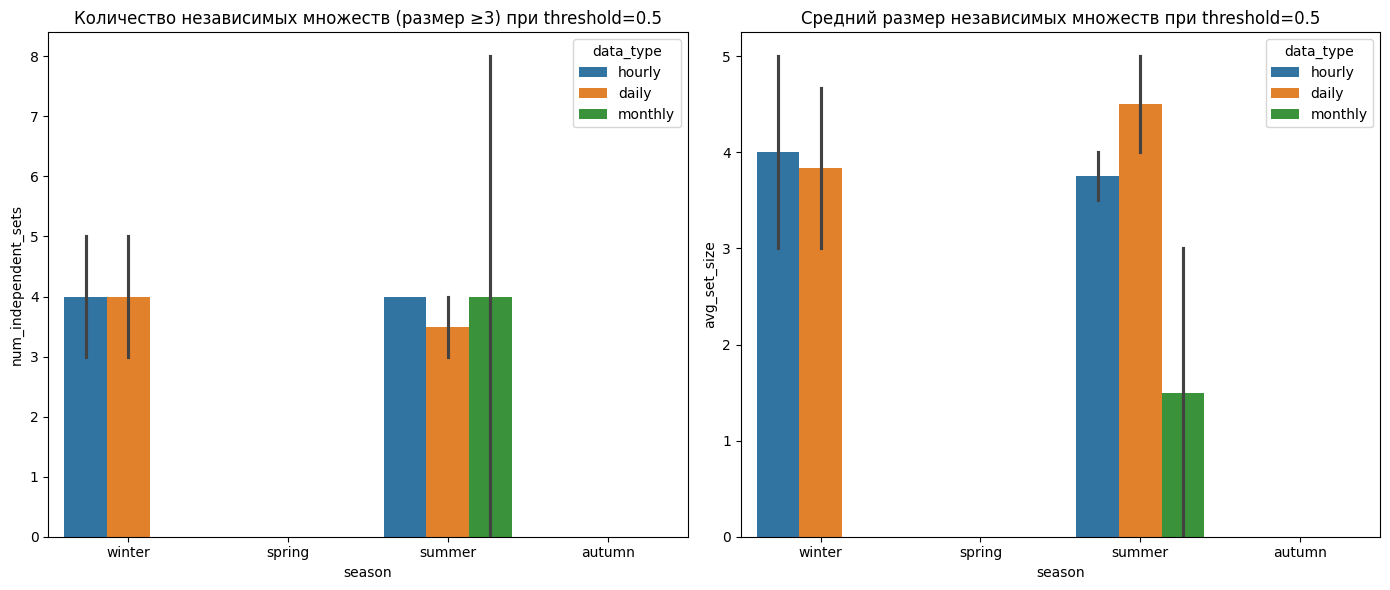


=== Устойчивые независимые множества (hourly, pearson, threshold=0.5) ===
Нет независимых множеств, общих для всех сезонов

=== Устойчивые независимые множества (daily, pearson, threshold=0.5) ===
Нет независимых множеств, общих для всех сезонов

=== Устойчивые независимые множества (monthly, pearson, threshold=0.5) ===
Нет независимых множеств, общих для всех сезонов


In [32]:
def analyze_and_compare_independent_sets(graphs_dict, min_set_size=3):
    """
    Анализирует и сравнивает структуру независимых множеств графов
    
    Параметры:
    ----------
    graphs_dict : dict
        Словарь с графами (результат функции build_pruned_graphs)
    min_set_size : int
        Минимальный размер независимого множества для анализа (по умолчанию 3)
    
    Возвращает:
    -----------
    pd.DataFrame
        Таблица с результатами анализа независимых множеств
    """
    independent_set_results = []
    
    for key, data in graphs_dict.items():
        G = data['graph']
        season, method, threshold = key
        
        # Находим все максимальные независимые множества
        # Используем дополнение графа, так как независимое множество в G - это клика в дополнении G
        complement_G = nx.complement(G)
        all_independent_sets = list(nx.find_cliques(complement_G))
        
        # Фильтруем множества по минимальному размеру
        significant_sets = [s for s in all_independent_sets if len(s) >= min_set_size]
        
        # Анализ пересечений множеств между сезонами (если данные доступны)
        common_cities = None
        if 'winter' in season or 'summer' in season:
            # Находим все города в значимых множествах
            cities_in_sets = set().union(*significant_sets)
            
            # Для сравнения с другим сезоном
            other_season = 'summer' if season == 'winter' else 'winter'
            other_key = (other_season, method, threshold)
            if other_key in graphs_dict:
                other_G = graphs_dict[other_key]['graph']
                other_complement = nx.complement(other_G)
                other_sets = [s for s in nx.find_cliques(other_complement) if len(s) >= min_set_size]
                other_cities = set().union(*other_sets)
                common_cities = cities_in_sets & other_cities
        
        independent_set_results.append({
            'season': season,
            'method': method,
            'threshold': threshold,
            'num_independent_sets': len(significant_sets),
            'avg_set_size': np.mean([len(s) for s in significant_sets]) if significant_sets else 0,
            'max_set_size': max([len(s) for s in significant_sets], default=0),
            'total_cities_in_sets': len(set().union(*significant_sets)) if significant_sets else 0,
            'common_with_opposite_season': len(common_cities) if common_cities is not None else None,
            'independent_set_members': significant_sets
        })
    
    return pd.DataFrame(independent_set_results)

# Анализ независимых множеств для разных типов данных
hourly_independent = analyze_and_compare_independent_sets(hourly_graphs)
daily_independent = analyze_and_compare_independent_sets(daily_graphs)
monthly_independent = analyze_and_compare_independent_sets(monthly_graphs)

# Объединение результатов
all_independent = pd.concat([
    hourly_independent.assign(data_type='hourly'),
    daily_independent.assign(data_type='daily'),
    monthly_independent.assign(data_type='monthly')
])

# Визуализация результатов
def plot_independent_set_comparison(df, threshold):
    plt.figure(figsize=(14, 6))
    
    # Количество независимых множеств
    plt.subplot(1, 2, 1)
    sns.barplot(data=df[df['threshold'] == threshold], 
               x='season', y='num_independent_sets', hue='data_type')
    plt.title(f'Количество независимых множеств (размер ≥3) при threshold={threshold}')
    
    # Средний размер множеств
    plt.subplot(1, 2, 2)
    sns.barplot(data=df[df['threshold'] == threshold], 
               x='season', y='avg_set_size', hue='data_type')
    plt.title(f'Средний размер независимых множеств при threshold={threshold}')
    
    plt.tight_layout()
    plt.show()

# Пример визуализации для порога 0.5
plot_independent_set_comparison(all_independent, 0.5)

# Анализ устойчивых независимых множеств (появляющихся в нескольких сезонах)
def analyze_stable_independent_sets(independent_df, method='pearson', threshold=0.5):
    # Группируем по типу данных
    for data_type in ['hourly', 'daily', 'monthly']:
        print(f"\n=== Устойчивые независимые множества ({data_type}, {method}, threshold={threshold}) ===")
        
        # Получаем множества для всех сезонов
        season_sets = {}
        for season in ['winter', 'spring', 'summer', 'autumn']:
            sets = independent_df[
                (independent_df['season'] == season) & 
                (independent_df['method'] == method) & 
                (independent_df['threshold'] == threshold) &
                (independent_df['data_type'] == data_type)
            ]['independent_set_members'].iloc[0]
            
            # Преобразуем множества для сравнения
            season_sets[season] = [frozenset(s) for s in sets]
        
        # Находим множества, общие для всех сезонов
        common_sets = set(season_sets['winter'])
        for season in ['spring', 'summer', 'autumn']:
            common_sets &= set(season_sets[season])
        
        if common_sets:
            print(f"Найдено {len(common_sets)} множеств, общих для всех сезонов:")
            for i, ind_set in enumerate(common_sets, 1):
                print(f"{i}. {sorted(ind_set)}")
        else:
            print("Нет независимых множеств, общих для всех сезонов")

# Пример анализа устойчивых независимых множеств
analyze_stable_independent_sets(all_independent)

In [ ]:
def compare_network_models(graphs_dict, metrics=None):
    """
    Сравнивает сетевые модели с разной частотой наблюдений по ключевым метрикам
    
    Параметры:
    ----------
    graphs_dict : dict
        Словарь с графами (формата {('season','method','threshold'): {'graph': G, ...}})
    metrics : list or None
        Список метрик для сравнения (по умолчанию базовые топологические метрики)
    
    Возвращает:
    -----------
    pd.DataFrame
        Таблица с результатами сравнения
    """
    if metrics is None:
        metrics = [
            'num_nodes',
            'num_edges',
            'density',
            'avg_degree',
            'avg_clustering',
            'transitivity',
            'avg_path_length',
            'diameter',
            'assortativity'
        ]
    
    results = []
    
    for key, data in graphs_dict.items():
        G = data['graph']
        season, method, threshold = key
        
        # Пропускаем несвязные графы для некоторых метрик
        is_connected = nx.is_connected(G) if G.number_of_nodes() > 0 else False
        
        metric_values = {
            'season': season,
            'method': method,
            'threshold': threshold,
            'data_type': data.get('data_type', 'unknown')
        }
        
        for metric in metrics:
            try:
                if metric == 'num_nodes':
                    value = G.number_of_nodes()
                elif metric == 'num_edges':
                    value = G.number_of_edges()
                elif metric == 'density':
                    value = nx.density(G)
                elif metric == 'avg_degree':
                    value = sum(dict(G.degree()).values()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0
                elif metric == 'avg_clustering':
                    value = nx.average_clustering(G)
                elif metric == 'transitivity':
                    value = nx.transitivity(G)
                elif metric == 'avg_path_length':
                    value = nx.average_shortest_path_length(G) if is_connected else float('nan')
                elif metric == 'diameter':
                    value = nx.diameter(G) if is_connected else float('nan')
                elif metric == 'assortativity':
                    value = nx.degree_assortativity_coefficient(G)
                else:
                    value = float('nan')
                
                metric_values[metric] = value
            except Exception as e:
                print(f"Ошибка при расчете {metric} для {key}: {str(e)}")
                metric_values[metric] = float('nan')
        
        results.append(metric_values)
    
    df = pd.DataFrame(results)
    
    # Добавляем производные показатели
    if {'num_nodes', 'num_edges'}.issubset(df.columns):
        df['edges_to_nodes_ratio'] = df['num_edges'] / df['num_nodes']
    
    return df

# Применение функции
network_comparison = compare_network_models({
    **{(k[0], k[1], k[2]): {'graph': v['graph'], 'data_type': 'hourly'} for k, v in hourly_graphs.items()},
    **{(k[0], k[1], k[2]): {'graph': v['graph'], 'data_type': 'daily'} for k, v in daily_graphs.items()},
    **{(k[0], k[1], k[2]): {'graph': v['graph'], 'data_type': 'monthly'} for k, v in monthly_graphs.items()}
})

# Визуализация сравнения
def plot_network_comparison(df, metric, threshold):
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df[(df['threshold'] == threshold) & (df['method'] == 'pearson')],
        x='season',
        y=metric,
        hue='data_type',
        palette='viridis'
    )
    plt.title(f'Сравнение {metric} между частотами наблюдений (threshold={threshold})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Примеры визуализаций
for metric in ['num_edges', 'density', 'avg_clustering', 'assortativity']:
    plot_network_comparison(network_comparison, metric, 0.5)

# 5. Выводы